In [4]:
import pandas as pd
import numpy as np
import datetime
from scorepi import *
from epiweeks import Week
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
import datetime
from datetime import datetime
from datetime import timedelta
from pathlib import Path
import matplotlib as mpl
import random
from numba import njit
from scipy.stats import linregress
from scipy.stats import nbinom
import warnings
warnings.filterwarnings('ignore')

In [5]:
# distribution parameters
mu=40
alpha=4
sig2 = 31

p =60/31**2
n = 60**2/(31**2-60)

In [6]:
from numba import njit
@njit
def energyscore(X,y):
    # X is matrix of trajectories, y is observations
    ES = 0
    N = X.shape[0]
    for i in range(N):
        ES += np.sqrt(np.sum((X[i]-y)**2))/N
    for i in range(N):
        for j in range(N):
            ES -= np.sqrt(np.sum((X[i]-X[j])**2))/(2*N**2)
    return ES


In [20]:
@njit
def normalized_energyscore(X,y):
    # X is matrix of trajectories, y is observations
    ES = 0
    N = X.shape[0]
    for i in range(N):
        ES += np.sqrt(np.sum(((X[i]-y)/y)**2))/N
    for i in range(N):
        for j in range(N):
            ES -= np.sqrt(np.sum(((X[i]-X[j])/y)**2))/(2*N**2)
    return ES

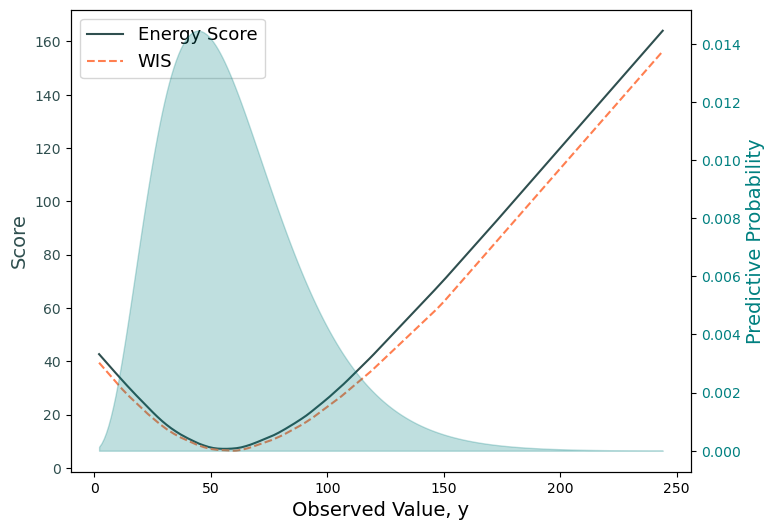

In [18]:
# scores at one time for synthetic predictive distribution

ESval = []
point = np.random.negative_binomial(n,p,100) # point predictions drawn from negative binomial distribution
traj = np.empty([100,1])
for i in range(len(point)):
    traj[i] = np.array(point[i])
    
# calculate energy score for different observed values
for x in np.arange(nbinom.ppf(0.0001, n, p), nbinom.ppf(0.9999, n, p)):
    ES = energyscore(traj, x)
    ESval.append(ES)


fig, ax1 = plt.subplots(figsize=(8,6))
# plot energy score values
color = 'darkslategray'
ax1.set_xlabel('Observed Value, y', fontsize=14)
ax1.set_ylabel('Score', color=color, fontsize=14)
ax1.plot(np.arange(nbinom.ppf(0.0001, n, p),
              nbinom.ppf(0.9999, n, p)), np.array(ESval), color=color, label='Energy Score')
ax1.tick_params(axis='y', labelcolor=color)


# calculate WIS for different observed values
WISval = []
    
for x in np.arange(nbinom.ppf(0.0001, n, p), nbinom.ppf(0.9999, n, p)):
    y = [x]
    
    # define quantiles to calculate WIS with
    quantiles=[0.01,0.025,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.60,0.65,0.7,0.75,0.8,0.85,0.9,0.95,0.975,0.99]
   # quantiles = np.linspace(0.001,0.999,101)
    
    Q = np.quantile(traj,quantiles,axis=0)
    WIS = np.zeros(traj.shape[1])
    for i in range(len(quantiles) // 2):
        #print(i)
        interval_range = 100*(quantiles[-i-1]-quantiles[i])
        alpha = 1-(quantiles[-i-1]-quantiles[i])
        IS = interval_score(y,Q[i],Q[-i-1],interval_range)
        WIS += IS['interval_score']*alpha/2
    WIS += 0.5*np.abs(Q[len(quantiles) // 2 +1] - y[0])
        
    WIS = np.sum(WIS) / (len(quantiles) // 2 + 0.5)
    
    WISval.append(WIS)


# plot WIS values
ax1.plot(np.arange(nbinom.ppf(0.0001, n, p),
              nbinom.ppf(0.9999, n, p)), np.array(WISval),'--', color='coral', label = 'WIS')
plt.legend(fontsize=13)


ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

# plot underlying predictive distribution
x = np.arange(nbinom.ppf(0.0001, n, p),
              nbinom.ppf(0.9999, n, p))

pmf = nbinom.pmf(x, n, p)

color = 'teal'
ax2.set_ylabel('Predictive Probability', color=color, fontsize=14)  

ax2.fill_between(x, nbinom.pmf(x, n, p),color=color, alpha=.25)
ax2.tick_params(axis='y', labelcolor=color)
#plt.axvline(x=60, ymin=0, ymax=160,linestyle='--', color = 'lightgray', alpha=1)


#plt.savefig('../figs/score_distribution.pdf')
plt.show()

# Look at decomposition of score at each week

In [19]:
from numba import njit
@njit
def energyscore_terms(X,y):
    # X is matrix of trajectories, y is observations
    # get the contribution of each term to the full energy score 
    ES1 = 0
    ES2 = 0
    N = X.shape[0]
    for i in range(N):
        ES1+=np.sqrt(np.sum((X[i]-y)**2))/N
    for i in range(N):
        for j in range(N):
            ES2 -= np.sqrt(np.sum((X[i]-X[j])**2))/(2*N**2)
    return ES1, ES2


In [4]:
# get predictions for MOBS model

target = 'hospitalization'
incidence=True
observations = pd.read_parquet(f"/Users/bay.c/Documents/GitHub/energy-score/fludat/truth_{'inc' if incidence else 'cum'}_{target}.pq")


models = 'MOBS_NEU-GLEAM_FLU'
predictionsall = pd.DataFrame()
for model in [models]:
    df = pd.read_parquet(f'/Users/bay.c/Documents/GitHub/energy-score/fludat/{model}_rd4.pq')
    print(model, len(df.location.unique()))
    
    predictionsall = pd.concat([predictionsall, df])
    
# filter by trajectories and only look at age group with all ages combined
predictions_traj = predictionsall[(predictionsall.output_type == 'sample') & \
                                   (predictionsall.age_group == '0-130')]
# filter by dates with data
predictions_traj = predictions_traj[predictions_traj.target_end_date <= pd.to_datetime(observations.date.max())]


start_week = pd.to_datetime('2023-09-09')
max_date = pd.to_datetime(observations.date.max())

   
# filter by dates with data
predictions = predictions_traj[(predictions_traj.target_end_date <= max_date) & 
                                (predictions_traj.Model == models)]  

MOBS_NEU-GLEAM_FLU 52


In [25]:
# filter predictions for scenario D and US
scenario = 'D'
location = 'US'
target = 'hosp'
incidence = True

map_alpha = lambda interval_range: 0.5 * (1-interval_range) + 0.1


if target == 'hosp':
    target_obs = 'hospitalization'
else:
    target_obs = target_obs
    

predictionsfilt = predictions[(predictions.scenario_id == scenario + '-2023-08-14') & \
                              (predictions.location == location) & \
                              (predictions.target == 'inc ' + target)  & \
                              (predictions.target_end_date <= max_date) & \
                              (predictions.target_end_date >= start_week)]


In [354]:
# calculate energy score for each week and for each term of the expression
observations['date'] = pd.to_datetime(observations['date'])

observations = observations[(observations['date'] >= start_week) & \
                                        (observations['date'] <= max_date)]   


#aggregate to weekly
observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

#transform to Observation object
observations = Observations(observations)

#filter location
observations = observations[observations['location'] == location]

ESsum = []
ESsub = []
ESall = []
for date in observations.date.unique():
    obs = observations[observations.date==date]
    pdf = predictionsfilt[predictionsfilt.target_end_date==date]
    
    y = np.array(obs.value)
    X = [np.array(pdf[pdf['output_type_id'] == i].value) for i in pdf['output_type_id'].unique()]

    # calculate energy score and separate terms
    ES1, ES2 = energyscore_terms(np.array(X),y)

    ES = energyscore(np.array(X), y)
    
    ESsum.append(ES1)
    ESsub.append(ES2)
    ESall.append(ES)

In [12]:
import matplotlib.dates as mdates
# plot formatting
def set_date_axis_fmt(ax):
    # Set the locator
    locator = mdates.MonthLocator()  # every month
    # Specify the format
    fmt = mdates.DateFormatter('%b %y')

    X = ax.xaxis
    X.set_major_locator(locator)
    # Specify formatter
    X.set_major_formatter(fmt)
    

([], [])

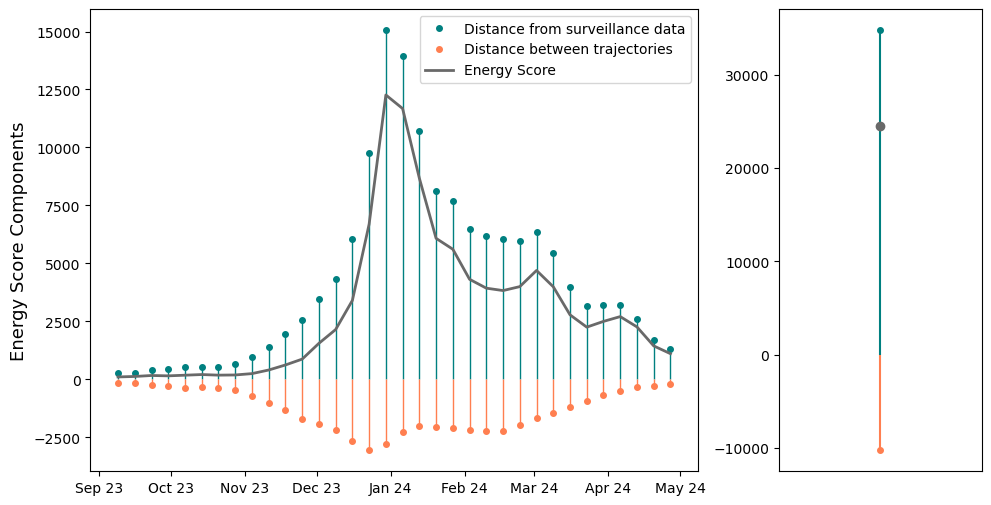

In [26]:
# calculate energy score for each week and plot
observations['date'] = pd.to_datetime(observations['date'])

observations = observations[(observations['date'] >= start_week) & \
                                        (observations['date'] <= max_date)]   


#aggregate to weekly
observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

#transform to Observation object
observations = Observations(observations)

#filter location
observations = observations[observations['location'] == location]

ESsum = []
ESsub = []
ESall = []
for date in observations.date.unique():
    obs = observations[observations.date==date]
    pdf = predictionsfilt[predictionsfilt.target_end_date==date]
    
    y = np.array(obs.value)
    X = [np.array(pdf[pdf['output_type_id'] == i].value) for i in pdf['output_type_id'].unique()]


    ES1, ES2 = energyscore_terms(np.array(X),y)

    ES = energyscore(np.array(X), y)
    
    ESsum.append(ES1)
    ESsub.append(ES2)
    ESall.append(ES)

dates = observations.date.unique()
fig, ax = plt.subplots(1,2,figsize=(11.5,6), width_ratios=[3, 1])
plt.subplot(1,2,1)
ax[0].vlines(dates, ymin=0, ymax=ESsum, color='teal', linewidth=1) 
  
# drawing the markers (circle) 
plt.plot(dates, ESsum, "o",markersize=4, color='teal', label='Distance from surveillance data') 

ax[0].vlines(dates, ymin=ESsub, ymax=0, color='coral', linewidth=1) 
plt.plot(dates, ESsub, "o",markersize=4, color='coral', label='Distance between trajectories') 
  
plt.plot(dates, ESall,linewidth=2, color='dimgray', label='Energy Score') 
set_date_axis_fmt(ax[0])
   
plt.legend()
plt.ylabel('Energy Score Components', fontsize=13)

# full ES
observations['date'] = pd.to_datetime(observations['date'])

observations = observations[(observations['date'] >= start_week) & \
                                        (observations['date'] <= max_date)]   

#aggregate to weekly
observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

#transform to Observation object
observations = Observations(observations)

#filter location
observations = observations[observations['location'] == location]

ESsum = []
ESsub = []
ESall = []
 
y = np.array(observations.value)
X = [np.array(predictionsfilt[predictionsfilt['output_type_id'] == i].value) for i in pdf['output_type_id'].unique()]


ES1, ES2 = energyscore_terms(np.array(X),y)

ES = energyscore(np.array(X), y)

ESsum.append(ES1)
ESsub.append(ES2)
ESall.append(ES)

plt.subplot(1,2,2)
ax[1].vlines([1],ymin=0, ymax=ESsum, color='teal') 
  
# drawing the markers (circle) 
plt.plot([1], ESsum, "o",markersize=4, color='teal', label='distance from surveillance data') 

ax[1].vlines([1], ymin=ESsub, ymax=0, color='coral') 
plt.plot([1], ESsub, "o",markersize=4, color='coral', label='distance between trajectories') 
  
plt.plot([1], ESall,'o' ,markersize=6,color='dimgray', label='energy score') 
   
#plt.legend()

plt.xticks([])

#plt.savefig('../figs/energyscore_decomp.pdf')

In [205]:
# calcualte WIS at each week


In [6]:
class ScoringObj:
    
    # this method takes the average of all quantiles to find one projection that is an ensemble of all scenarios.
    # performed for all projection locations reported in the given DataFrame
    
    # Input dataframe must have: location, scenario_id, target_end_date, target, value, type, and quantile columns
    
    def __init__(self, df, obsdf, target, incidence = True, max_date = False, start_week = False, end_week = False):
        self.df = df # input dataframe with all scenarios, locations, and quantiles
        self.obsdf = obsdf # input of surveillance data of interest
        self.target = target # target metric of interest (case, death, hospitalization)
        self.inc = incidence # True if incident measures, False if cumulative
        self.max_date = max_date # maximum date you want to analyze, cut off date
        self.start_week = start_week # beginning of observations of interest
        self.end_week = end_week # end of observations of interest
        self.locations = pd.DataFrame()
        self.scenario_ensemble = pd.DataFrame()
        
        
    def get_locations(self):
        # get df with US state names, populations, and abbreviations and corresponding numerical code 
        locations = pd.read_csv('./dat/locations.csv',dtype={'location':str})
        
        self.locations = locations
        
        return locations
        
        
    def get_observations(self, target_location):
        # get and format surveillance data of interest
        observations = self.obsdf.copy()
        
        if self.target == 'hosp':
            target_obs = 'hospitalization'
        else:
            target_obs = self.target
            
        # read in observations dataframe
        observations = self.obsdf.copy()
        observations['date'] = pd.to_datetime(observations['date'])

        #filter start - end week
        if self.start_week:
            observations = observations[(observations['date'] >= pd.to_datetime(self.start_week.startdate())) ]
            
        if self.end_week:
            observations = observations[(observations['date'] <= pd.to_datetime(self.end_week.enddate()))]
                                

        #filter location
        observations = observations[observations['location'] == target_location]

        #aggregate to weekly
        observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

        if self.max_date:
            observations = observations[observations['date'] <= max_date].copy()
            
        #observations = observations[['location', 'date', 'value']]

        #transform to Observation object
        observations = Observations(observations)

        return observations
    
    
    
    def format_forecasts(self, model, date, target_location):

        pred = pd.read_parquet(f"./dat/{model}_{date}.pq")
        pred['Model'] = model
        pred = pred[pred.output_type == 'quantile']
        pred['target_end_date'] = pd.to_datetime(pred['target_end_date'])
        if self.end_week:
            pred = pred[(pred['target_end_date'] <= pd.to_datetime(self.end_week.enddate()))]
        
        
        pred['output_type_id'] = pred["output_type_id"].astype(float)
        predictions = pred[pred['location'] == target_location].copy()

        return predictions
    
    
    def format_forecasts_all(self, dfformat):

        pred = dfformat.copy()
        pred = pred[pred.output_type == 'quantile']
        pred['target_end_date'] = pd.to_datetime(pred['target_end_date'])
        if self.end_week:
            pred = pred[(pred['target_end_date'] <= pd.to_datetime(self.end_week.enddate()))]
        
        
        pred['output_type_id'] = pred["output_type_id"].astype(float)
       # predictions = pred[pred['location'] == target_location].copy()

        return pred
        
    

class Scoring(ScoringObj):
    # calculate score values for probabilistic epidemic forecasts 
    # find WIS, MAPE, and coverage over whole projection window as well as timestamped for every week.
    # uses scorepi package to calculate the scores 
    # score dataframe must have 'Model' column to differentiate and calculate scores for different models
    
    def __init__(self, df, obsdf, target, incidence = True, max_date = False, start_week = False, 
                 end_week = False):
        super().__init__(df, obsdf, target, incidence, max_date, start_week, end_week)
        #self.scoredf = scoredf #dataframe we want to use to calculate performance analysis/scoring
        
    def get_all_average_scores(self, models, date):
        #predictions = self.scoredf.copy()
        #predictions = Predictions(predictions, t_col = 'target_end_date')
        pred1 = self.df.copy()
        loclist = list(pred1.location.unique())
        
        
        allscore = {}
        for model in models:
            allscore[model] = {}
            for target_location in loclist:
                if target_location == '72':
                    continue
                #print(target_location)
                
                observations = self.get_observations(target_location)

                #pred = self.format_forecasts(model=model, date = date, target_location = target_location)
                pred = pred1[(pred1.Model==model) & (pred1['location']==target_location)]
                pred = Predictions(pred, t_col = 'target_end_date', quantile_col = 'quantile')

                d,_ = score_utils.all_scores_from_df(observations, pred, mismatched_allowed=False)

                allscore[model][target_location] = d
            
        
        return allscore
    
    def organize_average_scores(self, want_scores, models, date):
        # want_scores is list of scores you want to save in the dataframe
        # wis is 'wis_mean', and all coverages are '10_cov', '20_cov', ... '95_cov' etc.
        
        average_scores = pd.DataFrame()
        
        allscore = self.get_all_average_scores(models, date)
        
        for model in allscore.keys():
            scoresmod = allscore[model]
            for loc in scoresmod.keys():
                
                    
                scoresloc = scoresmod[loc]

                scoredict = {'Model': model ,'location': loc}
                for score in want_scores:
                    scoredict[score] = scoresloc[score]


                average_scores = pd.concat([average_scores, pd.DataFrame(scoredict, index=[0])])

        
        average_scores = average_scores.reset_index() 
        average_scores = average_scores.drop(columns=['index'])
        
        return average_scores
    
    def get_all_timestamped_scores(self, models, date):
        pred = self.df.copy()
        loclist = list(pred.location.unique())
        
        allscore = {}
        
        for model in models:
            allscore[model] = {}
            for target_location in loclist:
                    
                observations = self.get_observations(target_location)
                
                try:
                    #pred = self.format_forecasts(model=model, date = date, target_location = target_location)
                    predss = pred[pred['location'] == target_location]
                    predss = Predictions(predss, t_col = 'target_end_date', quantile_col = 'quantile')
                    
                    if len(predss)==0:
                        continue
                    
                    allscore[model][target_location] = {}
                    for t in predss.target_end_date.unique():
                        prednew = predss[predss.target_end_date == t]
                        obsnew = observations[observations.date == t]

                        obsnew = Observations(obsnew)
                        prednew = Predictions(prednew, t_col = 'target_end_date', quantile_col = 'quantile')

                        d = score_utils.all_timestamped_scores_from_df(obsnew, prednew)

                        allscore[model][target_location][t] = d
                except Exception as e:
                    print(e)

        #self.allavgscores = allscore
        
        return allscore
    
    def organize_timestamped_scores(self, want_scores, models, date):
        # want_scores is list of scores you want to save in the dataframe
        # wis is 'wis'
        
        time_scores = pd.DataFrame()
        
        allscore = self.get_all_timestamped_scores(models=models, date=date)
        
        for model in allscore.keys():
            scoremod = allscore[model]
        
            for loc in scoremod.keys():
                    
                scoresloc = scoremod[loc]

                for t in scoresloc.keys():
                    tdf = scoresloc[t]

                    scoredict = {'Model':model ,'location':loc, 'target_end_date':t}
                    for score in want_scores:
                        scoredict[score] = tdf[score]


                    time_scores = pd.concat([time_scores, pd.DataFrame(scoredict, index=[0])])

        
        time_scores = time_scores.reset_index() 
        time_scores = time_scores.drop(columns=['index'])
        
        return time_scores
    

In [27]:
# get quantiles of trajectories to calculate WIS
quantiles=[0.01,0.025,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.60,
                        0.65,0.7,0.75,0.8,0.85,0.9,0.95,0.975,0.99]
    

predictionsfilt = predictions[(predictions.scenario_id == scenario + '-2023-08-14') & \
                              (predictions.location == location) & \
                              (predictions.target == 'inc ' + target)  & \
                              (predictions.target_end_date <= max_date) & \
                              (predictions.target_end_date >= start_week)]


X = [np.array(predictionsfilt[predictionsfilt['output_type_id'] == i].value) for i in pdf['output_type_id'].unique()]

# get quantiles
Q = np.quantile(X,quantiles,axis=0)


dates = predictionsfilt.target_end_date.unique()
predictionsquant = pd.DataFrame()
for i in range(len(quantiles)):
    quant = quantiles[i]
    val = Q[i]
    
    row = pd.DataFrame({'scenario_id':scenario+'-2023-08-14', 'location':'US', 'target':'inc hosp', 
                        'Model':'MOBS_NEU-GLEAM_FLU', 'target_end_date':dates, 'quantile':quant, 'value':val})
    
    predictionsquant = pd.concat([predictionsquant, row])

In [29]:
# get scores for each week and decompose by WIS term
test = Scoring(df=predictionsquant, obsdf=observations, target='hosp', incidence = True, max_date = False, 
                        start_week = Week(2023, 36), end_week = Week(2024, 17))

out = test.organize_timestamped_scores(want_scores = ['10_interval_score', '10_dispersion', '10_underprediction',
       '10_overprediction', '20_interval_score', '20_dispersion',
       '20_underprediction', '20_overprediction', '30_interval_score',
       '30_dispersion', '30_underprediction', '30_overprediction',
       '40_interval_score', '40_dispersion', '40_underprediction',
       '40_overprediction', '50_interval_score', '50_dispersion',
       '50_underprediction', '50_overprediction', '60_interval_score',
       '60_dispersion', '60_underprediction', '60_overprediction',
       '70_interval_score', '70_dispersion', '70_underprediction',
       '70_overprediction', '80_interval_score', '80_dispersion',
       '80_underprediction', '80_overprediction', '90_interval_score',
       '90_dispersion', '90_underprediction', '90_overprediction',
       '95_interval_score', '95_dispersion', '95_underprediction',
       '95_overprediction', '98_interval_score', '98_dispersion',
       '98_underprediction', '98_overprediction', 'wis'], models = [model], date='2023-08-14')

#out = test.get_all_timestamped_scores( models = [model], date='2023-08-14')
outtimestamp = out

In [30]:
weights = []
pis = [.1, .2, .3, .4, .5, .6, .7, .8, .9, .95, .98]
for i in pis:
    weights.append(1-i)

In [31]:
# save WIS terms
dispersion = out[['10_dispersion', '20_dispersion', '30_dispersion', '40_dispersion', '50_dispersion',
                 '60_dispersion', '70_dispersion', '80_dispersion', '90_dispersion', '95_dispersion',
                 '98_dispersion']]

underprediction = out[['10_underprediction', '20_underprediction', '30_underprediction', '40_underprediction', 
                       '50_underprediction', '60_underprediction', '70_underprediction', '80_underprediction', 
                       '90_underprediction', '95_underprediction', '98_underprediction']]

overprediction = out[['10_overprediction', '20_overprediction', '30_overprediction', '40_overprediction', 
                       '50_overprediction', '60_overprediction', '70_overprediction', '80_overprediction', 
                       '90_overprediction', '95_overprediction', '98_overprediction']]

In [32]:
# calculate contribution of each term
dispersion['10_dispersion'] = dispersion['10_dispersion']*(weights[0]/2)*1/(11.5)
dispersion['20_dispersion'] = dispersion['20_dispersion']*(weights[1]/2)*1/(11.5)
dispersion['30_dispersion'] = dispersion['30_dispersion']*(weights[2]/2)*1/(11.5)
dispersion['40_dispersion'] = dispersion['40_dispersion']*(weights[3]/2)*1/(11.5)
dispersion['50_dispersion'] = dispersion['50_dispersion']*(weights[4]/2)*1/(11.5)
dispersion['60_dispersion'] = dispersion['60_dispersion']*(weights[5]/2)*1/(11.5)
dispersion['70_dispersion'] = dispersion['70_dispersion']*(weights[6]/2)*1/(11.5)
dispersion['80_dispersion'] = dispersion['80_dispersion']*(weights[7]/2)*1/(11.5)
dispersion['90_dispersion'] = dispersion['90_dispersion']*(weights[8]/2)*1/(11.5)
dispersion['95_dispersion'] = dispersion['95_dispersion']*(weights[9]/2)*1/(11.5)
dispersion['98_dispersion'] = dispersion['98_dispersion']*(weights[10]/2)*1/(11.5)

underprediction['10_underprediction'] = underprediction['10_underprediction']*(weights[0]/2)*1/(11.5)
underprediction['20_underprediction'] = underprediction['20_underprediction']*(weights[1]/2)*1/(11.5)
underprediction['30_underprediction'] = underprediction['30_underprediction']*(weights[2]/2)*1/(11.5)
underprediction['40_underprediction'] = underprediction['40_underprediction']*(weights[3]/2)*1/(11.5)
underprediction['50_underprediction'] = underprediction['50_underprediction']*(weights[4]/2)*1/(11.5)
underprediction['60_underprediction'] = underprediction['60_underprediction']*(weights[5]/2)*1/(11.5)
underprediction['70_underprediction'] = underprediction['70_underprediction']*(weights[6]/2)*1/(11.5)
underprediction['80_underprediction'] = underprediction['80_underprediction']*(weights[7]/2)*1/(11.5)
underprediction['90_underprediction'] = underprediction['90_underprediction']*(weights[8]/2)*1/(11.5)
underprediction['95_underprediction'] = underprediction['95_underprediction']*(weights[9]/2)*1/(11.5)
underprediction['98_underprediction'] = underprediction['98_underprediction']*(weights[10]/2)*1/(11.5)

overprediction['10_overprediction'] = overprediction['10_overprediction']*(weights[0]/2)*1/(11.5)
overprediction['20_overprediction'] = overprediction['20_overprediction']*(weights[1]/2)*1/(11.5)
overprediction['30_overprediction'] = overprediction['30_overprediction']*(weights[2]/2)*1/(11.5)
overprediction['40_overprediction'] = overprediction['40_overprediction']*(weights[3]/2)*1/(11.5)
overprediction['50_overprediction'] = overprediction['50_overprediction']*(weights[4]/2)*1/(11.5)
overprediction['60_overprediction'] = overprediction['60_overprediction']*(weights[5]/2)*1/(11.5)
overprediction['70_overprediction'] = overprediction['70_overprediction']*(weights[6]/2)*1/(11.5)
overprediction['80_overprediction'] = overprediction['80_overprediction']*(weights[7]/2)*1/(11.5)
overprediction['90_overprediction'] = overprediction['90_overprediction']*(weights[8]/2)*1/(11.5)
overprediction['95_overprediction'] = overprediction['95_overprediction']*(weights[9]/2)*1/(11.5)
overprediction['98_overprediction'] = overprediction['98_overprediction']*(weights[10]/2)*1/(11.5)

In [37]:

dispersion['total'] = dispersion['10_dispersion'] + dispersion['20_dispersion'] + dispersion['30_dispersion'] + \
                      dispersion['40_dispersion'] + dispersion['50_dispersion'] + dispersion['60_dispersion'] + \
                      dispersion['70_dispersion'] + dispersion['80_dispersion'] + dispersion['90_dispersion'] + \
                      dispersion['95_dispersion'] + dispersion['98_dispersion'] 

underprediction['total'] = underprediction['10_underprediction'] + underprediction['20_underprediction'] + \
                           underprediction['30_underprediction'] + underprediction['40_underprediction'] + \
                           underprediction['50_underprediction'] + underprediction['60_underprediction'] + \
                           underprediction['70_underprediction'] + underprediction['80_underprediction'] + \
                           underprediction['90_underprediction'] + underprediction['95_underprediction'] + \
                           underprediction['98_underprediction'] 

overprediction['total'] = overprediction['10_overprediction'] + overprediction['20_overprediction'] + \
                           overprediction['30_overprediction'] + overprediction['40_overprediction'] + \
                           overprediction['50_overprediction'] + overprediction['60_overprediction'] + \
                           overprediction['70_overprediction'] + overprediction['80_overprediction'] + \
                           overprediction['90_overprediction'] + overprediction['95_overprediction'] + \
                           overprediction['98_overprediction'] 

([], [])

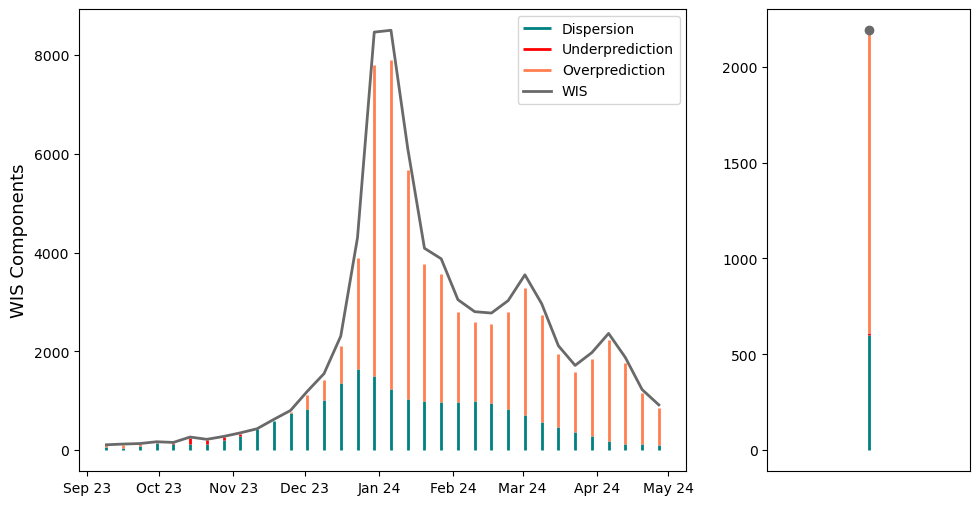

In [411]:
# plot WIS at each week and the contribution of each term in the expression

dates = observations.date.unique()
fig, ax = plt.subplots(1,2,figsize=(11.5,6), width_ratios=[3, 1])
plt.subplot(1,2,1)
ax[0].vlines(dates, ymin=0, ymax=dispersion.total, color='teal', linewidth=2, label='Dispersion') 
#plt.plot(dates, dispersion.total, "o",markersize=4, color='teal', label='dispersion') 

ax[0].vlines(dates, ymin=dispersion.total, ymax=dispersion.total+underprediction.total, color='red', linewidth=2,
          label='Underprediction') 
#plt.plot(dates, dispersion.total+underprediction.total, "o",markersize=4, color='red', label='underprediction') 

ax[0].vlines(dates, ymin=dispersion.total+underprediction.total, 
          ymax=overprediction.total+dispersion.total+underprediction.total, color='coral', linewidth=2,
         label='Overprediction') 
#plt.plot(dates, overprediction.total+dispersion.total+underprediction.total, "o",markersize=4, color='coral', 
#         label='overprediction') 

  
plt.plot(dates, outtimestamp.wis,'-' ,linewidth=2, color='dimgray', label='WIS') 
   
plt.legend()
#plt.yscale('log')
#plt.title('WIS')
plt.ylabel('WIS Components', fontsize=13)
set_date_axis_fmt(ax[0])


# full WIS

test = Scoring(df=predictionsquant, obsdf=observations, target='hosp', incidence = True, max_date = False, 
                        start_week = Week(2023, 36), end_week = Week(2024, 17))

out = test.organize_average_scores(want_scores = ['dispersion_wis_fraction', 'underprediction_wis_fraction', 
                                                  'overprediction_wis_fraction', 'wis_mean'], 
                                                   models = [model], date='2023-08-14')

out['dispersion'] = out['dispersion_wis_fraction'] * out['wis_mean']
out['underprediction'] = out['underprediction_wis_fraction'] * out['wis_mean']
out['overprediction'] = out['overprediction_wis_fraction'] * out['wis_mean']


plt.subplot(1,2,2)

ax[1].vlines([1],ymin=0, ymax=out['dispersion'], color='teal', lw=2) 
  
ax[1].vlines([1], ymin=out['dispersion'], ymax=out['dispersion'] + out['underprediction'], color='red', lw=2) 
ax[1].vlines([1], ymin=out['dispersion']+out['underprediction'], 
          ymax=out['dispersion']+ out['underprediction'] + out['overprediction'], color='coral', lw=2) 

plt.plot([1], out['wis_mean'],'o' ,markersize=6,color='dimgray', label='WIS') 

#plt.legend()

plt.xticks([])


#plt.savefig('../figs/WIS_components.pdf')

# Score components for normalized energy score

In [40]:
from numba import njit
@njit
def energyscore_terms_norm(X,y):
    # X is matrix of trajectories, y is observations
    ES1 = 0
    ES2 = 0
    N = X.shape[0]
    for i in range(N):
        ES1+=np.sqrt(np.sum(((X[i]-y)/y)**2))/N
    for i in range(N):
        for j in range(N):
            ES2 -= np.sqrt(np.sum(((X[i]-X[j])/y)**2))/(2*N**2)
    return ES1, ES2


In [45]:
@njit
def normalized_energyscore(X,y):
    # X is matrix of trajectories, y is observations
    ES = 0
    N = X.shape[0]
    for i in range(N):
        ES += np.sqrt(np.sum(((X[i]-y)/y)**2))/N
    for i in range(N):
        for j in range(N):
            ES -= np.sqrt(np.sum(((X[i]-X[j])/y)**2))/(2*N**2)
    return ES

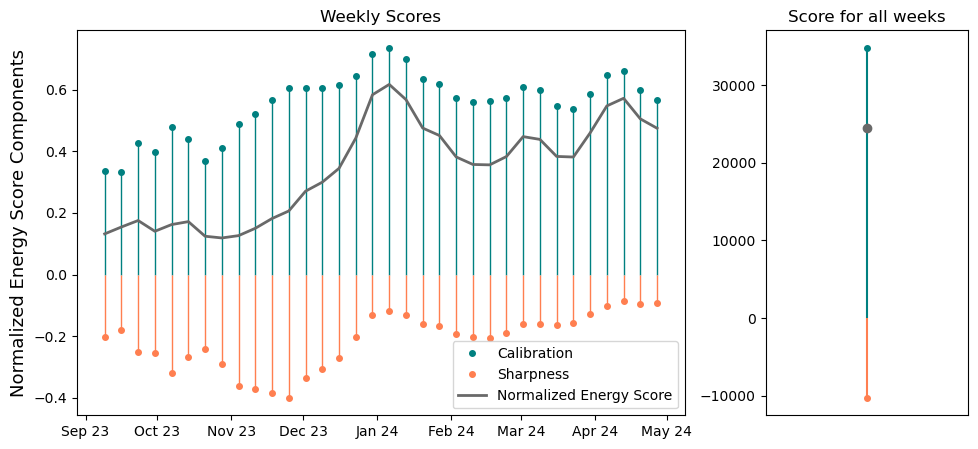

In [49]:
# plot normalized energy score at each week and the contribution of each term

# ES for each week
observations['date'] = pd.to_datetime(observations['date'])

observations = observations[(observations['date'] >= start_week) & \
                                        (observations['date'] <= max_date)]   


#aggregate to weekly
observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

#transform to Observation object
observations = Observations(observations)

#filter location
observations = observations[observations['location'] == location]

ESsum = []
ESsub = []
ESall = []
for date in observations.date.unique():
    obs = observations[observations.date==date]
    pdf = predictionsfilt[predictionsfilt.target_end_date==date]
    
    y = np.array(obs.value)
    X = [np.array(pdf[pdf['output_type_id'] == i].value) for i in pdf['output_type_id'].unique()]


    ES1, ES2 = energyscore_terms_norm(np.array(X),y)

    ES = normalized_energyscore(np.array(X), y)
    
    ESsum.append(ES1)
    ESsub.append(ES2)
    ESall.append(ES)

dates = observations.date.unique()
fig, ax = plt.subplots(1,2,figsize=(11.5,5), width_ratios=[3, 1])
plt.subplot(1,2,1)
ax[0].vlines(dates, ymin=0, ymax=ESsum, color='teal', linewidth=1) 
  
# drawing the markers (circle) 
plt.plot(dates, ESsum, "o",markersize=4, color='teal', label='Calibration') 

ax[0].vlines(dates, ymin=ESsub, ymax=0, color='coral', linewidth=1) 
plt.plot(dates, ESsub, "o",markersize=4, color='coral', label='Sharpness') 
  
plt.plot(dates, ESall,linewidth=2, color='dimgray', label='Normalized Energy Score') 
set_date_axis_fmt(ax[0])
   
plt.legend()
plt.ylabel('Normalized Energy Score Components', fontsize=13)

plt.title('Weekly Scores')

# full ES
observations['date'] = pd.to_datetime(observations['date'])

observations = observations[(observations['date'] >= start_week) & \
                                        (observations['date'] <= max_date)]   

#aggregate to weekly
observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

#transform to Observation object
observations = Observations(observations)

#filter location
observations = observations[observations['location'] == location]

ESsum = []
ESsub = []
ESall = []
 
y = np.array(observations.value)
X = [np.array(predictionsfilt[predictionsfilt['output_type_id'] == i].value) for i in pdf['output_type_id'].unique()]


ES1, ES2 = energyscore_terms(np.array(X),y)

ES = energyscore(np.array(X), y)

ESsum.append(ES1)
ESsub.append(ES2)
ESall.append(ES)

plt.subplot(1,2,2)
ax[1].vlines([1],ymin=0, ymax=ESsum, color='teal') 
  
# drawing the markers (circle) 
plt.plot([1], ESsum, "o",markersize=4, color='teal', label='Calibration') 

ax[1].vlines([1], ymin=ESsub, ymax=0, color='coral') 
plt.plot([1], ESsub, "o",markersize=4, color='coral', label='Sharpness') 
  
plt.plot([1], ESall,'o' ,markersize=6,color='dimgray', label='Normalized energy score') 
   
#plt.legend()

plt.xticks([])
plt.title('Score for all weeks')
plt.savefig('../figs/normalized_energyscore_decomp.pdf')


